# Red Neuronal para Clasificación de Géneros Musicales (GTZAN)

En este proyecto construiremos una red neuronal capaz de **clasificar fragmentos de 20 segundos de canciones en diferentes géneros musicales**, utilizando el dataset GTZAN. El objetivo es explorar la capacidad de las redes neuronales para identificar patrones característicos de cada género musical a partir de representaciones en espectrograma de audio.

El problema resulta interesante porque, aunque los fragmentos de audio son cortos y para un humano pueden ser insuficientes para identificar el género, una red neuronal puede aprender a distinguir patrones rítmicos, armónicos y de timbre que caracterizan a cada género musical. Esto tiene aplicaciones en sistemas de recomendación, organización automática de bibliotecas musicales y análisis de grandes volúmenes de audio.

**Sobre el dataset:**
- Utilizaremos el **GTZAN Genre Collection**, un dataset clásico en tareas de clasificación de géneros musicales.
- Cada archivo de audio tiene una duración de 30 segundos, pero en este proyecto nos centraremos en fragmentos de 20 segundos.
- El dataset contiene archivos de audio organizados por géneros, con un total de 10 etiquetas: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock.

**Flujo general del proyecto:**
1. Cargar y preprocesar los datos, obteniendo espectrogramas de los fragmentos de audio.
2. Construir y entrenar una red neuronal capaz de clasificar el género musical.
3. Evaluar el desempeño del modelo y analizar los resultados.

---

In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# Opcional: estilos para gráficos (puedes cambiarlo si tienes un archivo de estilos propio)
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (11, 5)
colores = ["#348ABD", "#A60628", "#06A628"]

# Configuración de dispositivo (CPU/GPU)
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cpu


### Carga y preprocesamiento de datos

En esta sección se cargan los datos de audio del dataset GTZAN y se procesan para obtener espectrogramas, que utilizaremos como entrada para la red neuronal. También se explora la estructura del dataset y se visualizan algunos ejemplos.

In [2]:
import os

# Ruta al dataset GTZAN (ajusta según tu descarga)
DATASET_PATH = './genres'
GENRES = sorted(os.listdir(DATASET_PATH))
print("Géneros encontrados:", GENRES)

Géneros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


#### Función para obtener espectrogramas de los audios

Convertimos los archivos de audio a espectrogramas de Mel, que son una representación visual de las frecuencias presentes en el audio a lo largo del tiempo.

In [3]:
import librosa
import numpy as np

"""
def extract_melspectrogram(file_path, n_mels=128, duration=20, sr=22050):
    y, sr = librosa.load(file_path, duration=duration, sr=sr, backend='audioread')
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db
"""

def extract_melspectrogram(file_path, n_mels=128, duration=20, sr=22050):
    try:
        y, sr = librosa.load(file_path, duration=duration, sr=sr)
    except Exception as e:
        print(f"Error con soundfile en {file_path}: {e}")
        # Intentar con audioread explícitamente
        import audioread
        try:
            with audioread.audio_open(file_path) as f:
                # Si audioread lo puede abrir, volver a intentar con librosa
                y, sr = librosa.load(file_path, sr=sr)
        except Exception as e2:
            print(f"No se pudo cargar {file_path} con audioread: {e2}")
            return None
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

# Procesar todos los archivos
spectrograms = []
labels = []

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)
    for fname in os.listdir(genre_path):
        if fname.endswith('.wav'):
            file_path = os.path.join(genre_path, fname)
            spec = extract_melspectrogram(file_path)
            if spec is not None:
                spectrograms.append(spec)
                labels.append(genre)

spectrograms = np.array(spectrograms)
labels = np.array(labels)
print("Cantidad total de muestras:", len(labels))

/var/folders/28/67xs7ppx1zvf4c_kxjqdb20c0000gn/T/ipykernel_1572/1313755195.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=duration, sr=sr)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error con soundfile en ./genres/jazz/jazz.00054.wav: 
No se pudo cargar ./genres/jazz/jazz.00054.wav con audioread: 
Cantidad total de muestras: 999


#### Visualización de algunos espectrogramas de ejemplo

A continuación se muestran algunos espectrogramas junto con su género correspondiente, para tener una idea visual de cómo son los datos de entrada.

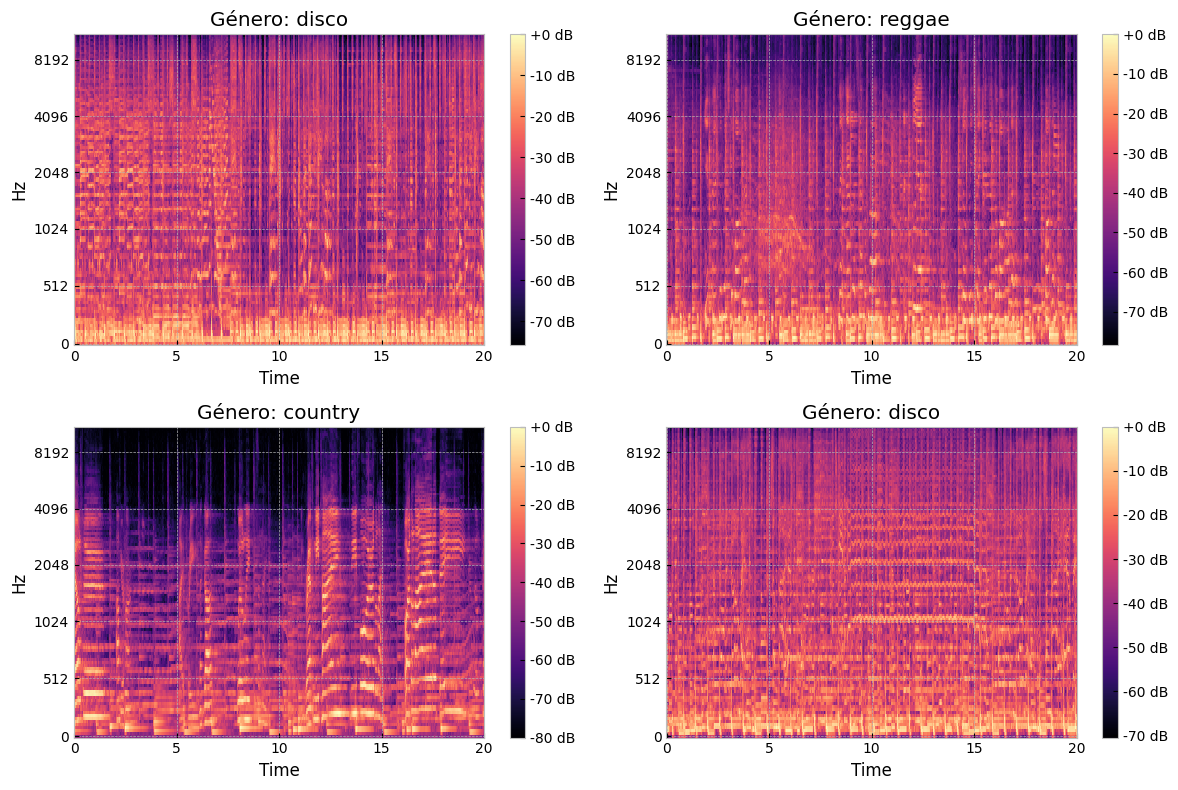

In [4]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(12, 8))
for i, idx in enumerate(np.random.choice(len(spectrograms), 4, replace=False)):
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(spectrograms[idx], y_axis='mel', x_axis='time')
    plt.title(f"Género: {labels[idx]}")
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

#### Resumen del dataset

Por último, revisamos la cantidad de muestras por género y otras estadísticas relevantes.

In [5]:
import pandas as pd

df = pd.DataFrame({'genre': labels})
print(df['genre'].value_counts())

genre
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: count, dtype: int64


### Definición del modelo de red neuronal

En esta sección se define la arquitectura de la red neuronal que se utilizará para clasificar los géneros musicales a partir de los espectrogramas de los fragmentos de audio.

La arquitectura elegida es una **Red Neuronal Convolucional (CNN)**, ya que este tipo de redes es especialmente efectiva para analizar datos estructurados en forma de imagen, como lo son los espectrogramas. Las capas convolucionales permiten extraer patrones locales de frecuencia y tiempo, mientras que las capas densas finales realizan la clasificación entre los géneros musicales.

---

#### Arquitectura propuesta

- **Capas convolucionales:** Extraen características locales del espectrograma.
- **Capas de pooling:** Reducen la dimensionalidad y ayudan a captar características invariantes.
- **Batch Normalization y Dropout:** Mejoran la estabilidad y generalización del entrenamiento.
- **Capas densas (fully connected):** Integran la información extraída y realizan la clasificación final usando softmax.

---

#### Implementación del modelo

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MusicGenreCNN(nn.Module):
    def __init__(self, n_classes):
        super(MusicGenreCNN, self).__init__()
        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.4)

        # Cálculo automático del tamaño final
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 862)  # (batch, channel, n_mels, time)
            x = self.pool1(F.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool2(F.relu(self.bn2(self.conv2(x))))
            x = self.pool3(F.relu(self.bn3(self.conv3(x))))
            flatten_size = x.view(1, -1).shape[1]

        # Capa completamente conectada para clasificación
        #self.fc1 = nn.Linear(128 * 16 * 8, 256)
        self.fc1 = nn.Linear(flatten_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Resumen de capas y funciones de activación:**

- Las capas **Conv2d** aprenden patrones espaciales locales sobre los espectrogramas.
- Las capas **BatchNorm2d** estabilizan el aprendizaje y aceleran la convergencia.
- Las capas **MaxPool2d** reducen el tamaño espacial de la representación.
- Las capas **Dropout** ayudan a evitar sobreajuste.
- Las capas **fc1** y **fc2** realizan la clasificación, usando ReLU en la primera y softmax (implícito en el loss) en la salida.

### Preparación de funciones auxiliares

En esta sección se definen funciones auxiliares para el manejo y transformación de los datos, así como para el proceso de entrenamiento, evaluación y predicción del modelo. Estas funciones permiten modularizar el código y facilitar la reutilización durante el flujo completo del experimento.

#### Funciones para manejo de datos y batches

Las siguientes funciones ayudan a transformar los datos y crear batches para el entrenamiento eficiente del modelo.

In [7]:
from torch.utils.data import Dataset, DataLoader

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, label_mapping):
        self.spectrograms = spectrograms
        self.labels = labels
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        # Normalizamos y convertimos a tensor
        x = torch.tensor(self.spectrograms[idx], dtype=torch.float32).unsqueeze(0)  # Añade canal
        y = torch.tensor(self.label_mapping[self.labels[idx]], dtype=torch.long)
        return x, y

# Ejemplo de uso:
# label_mapping = {genre: i for i, genre in enumerate(GENRES)}
# train_dataset = SpectrogramDataset(X_train, y_train, label_mapping)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### Funciones para entrenamiento, evaluación y predicción

A continuación se definen las funciones para entrenar el modelo por épocas, evaluar su desempeño y realizar predicciones sobre nuevos ejemplos.

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    running_corrects = 0
    total = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == targets).sum().item()
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == targets).sum().item()
            total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def predict(model, spectrogram, device):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        outputs = model(x)
        _, pred = torch.max(outputs, 1)
        return pred.item()

### Entrenamiento del modelo

En esta sección se realiza el entrenamiento del modelo, incluyendo la definición de los hiperparámetros, la inicialización del modelo y su optimizador, así como el ciclo de entrenamiento. También se visualizan las curvas de pérdida y precisión para monitorear el desempeño del modelo durante el entrenamiento.

#### Definición de hiperparámetros y preparación de datos

In [9]:
# Hiperparámetros
learning_rate = 0.001
num_epochs = 75
batch_size = 32

# Mapeo de géneros a índices
label_mapping = {genre: i for i, genre in enumerate(GENRES)}

# Separar los datos en train, val y test (aquí puedes usar tu split preferido)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(spectrograms, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Crear datasets y dataloaders
train_dataset = SpectrogramDataset(X_train, y_train, label_mapping)
val_dataset = SpectrogramDataset(X_val, y_val, label_mapping)
test_dataset = SpectrogramDataset(X_test, y_test, label_mapping)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Inicialización del modelo, criterio de pérdida y optimizador

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_classes = len(GENRES)
model = MusicGenreCNN(n_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#### Ciclo de entrenamiento

Durante el ciclo de entrenamiento se imprime periódicamente la pérdida y la precisión en los conjuntos de entrenamiento y validación.

In [11]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)  # Ajustar la tasa de aprendizaje si es necesario
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | " 
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/75 | Train Loss: 56.4896 | Train Acc: 0.1474 | Val Loss: 32.8905 | Val Acc: 0.1200
Epoch 2/75 | Train Loss: 5.4183 | Train Acc: 0.2375 | Val Loss: 3.3456 | Val Acc: 0.3067
Epoch 3/75 | Train Loss: 2.3449 | Train Acc: 0.2861 | Val Loss: 2.1899 | Val Acc: 0.2200
Epoch 4/75 | Train Loss: 1.9995 | Train Acc: 0.2804 | Val Loss: 2.2867 | Val Acc: 0.2133
Epoch 5/75 | Train Loss: 1.9653 | Train Acc: 0.2833 | Val Loss: 2.1910 | Val Acc: 0.2000
Epoch 6/75 | Train Loss: 2.0327 | Train Acc: 0.3076 | Val Loss: 2.1507 | Val Acc: 0.2333
Epoch 7/75 | Train Loss: 1.8427 | Train Acc: 0.3333 | Val Loss: 2.1628 | Val Acc: 0.2400
Epoch 8/75 | Train Loss: 1.7697 | Train Acc: 0.3577 | Val Loss: 2.0638 | Val Acc: 0.3333
Epoch 9/75 | Train Loss: 1.7089 | Train Acc: 0.4206 | Val Loss: 2.0931 | Val Acc: 0.3067
Epoch 10/75 | Train Loss: 1.6572 | Train Acc: 0.4177 | Val Loss: 2.0558 | Val Acc: 0.3267
Epoch 11/75 | Train Loss: 1.5900 | Train Acc: 0.4621 | Val Loss: 2.0653 | Val Acc: 0.3267
Epoch 12/75 | Tra

#### Visualización de la curva de aprendizaje

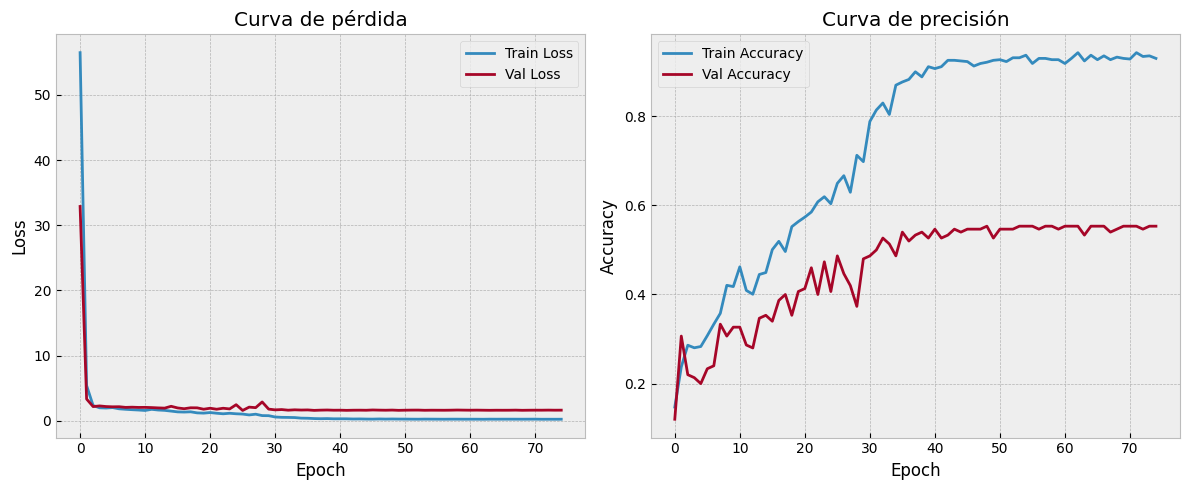

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Curva de precisión')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluación y resultados

En esta sección se evalúa el desempeño del modelo entrenado sobre el conjunto de prueba. Además, se visualizan los resultados obtenidos mediante una matriz de confusión y algunos ejemplos de predicciones, para analizar la capacidad del modelo para distinguir entre los diferentes géneros musicales.

#### Evaluación del modelo en el conjunto de prueba

A continuación, se calcula la precisión final del modelo y la pérdida sobre los datos de prueba.

In [13]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_acc:.2%}")

Pérdida en test: 1.4889
Precisión en test: 58.67%


#### Visualización de la matriz de confusión

La matriz de confusión permite observar cuáles géneros son más difíciles de distinguir para el modelo, mostrando los errores de clasificación más frecuentes.

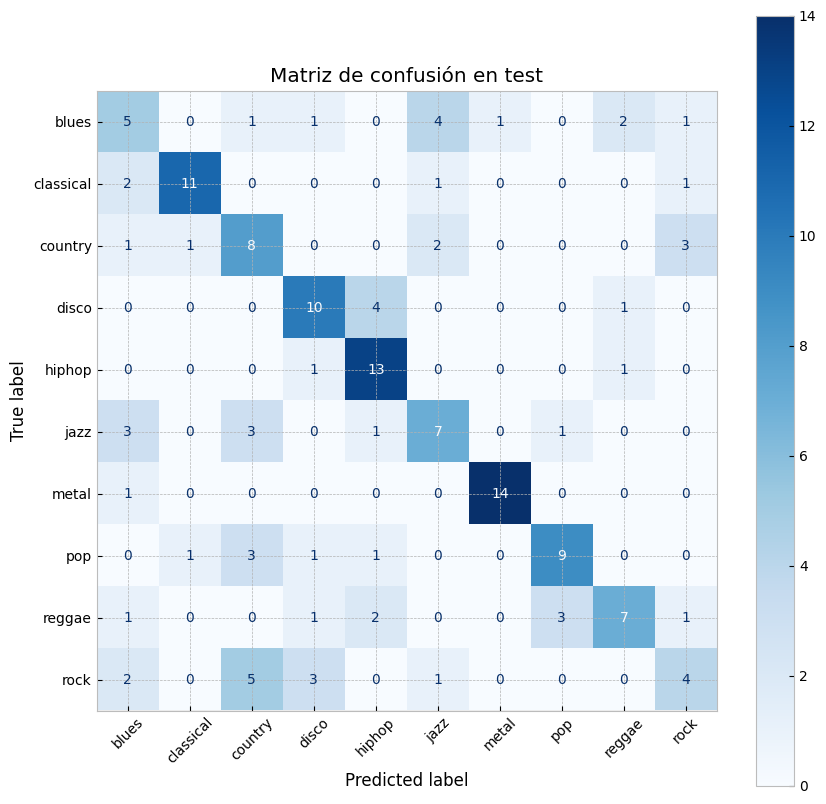

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener todas las predicciones y etiquetas reales
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión en test")
plt.show()

#### Ejemplos de predicciones

A continuación, se muestran algunos ejemplos de espectrogramas del conjunto de prueba junto con su género real y el género predicho por el modelo.

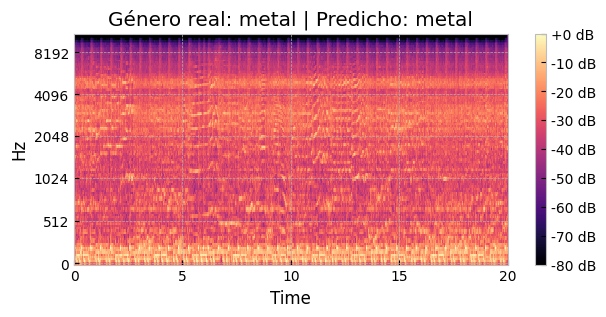

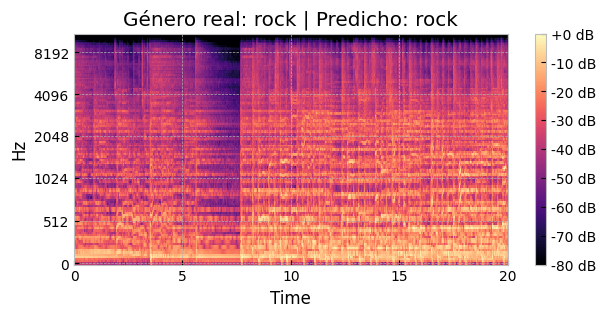

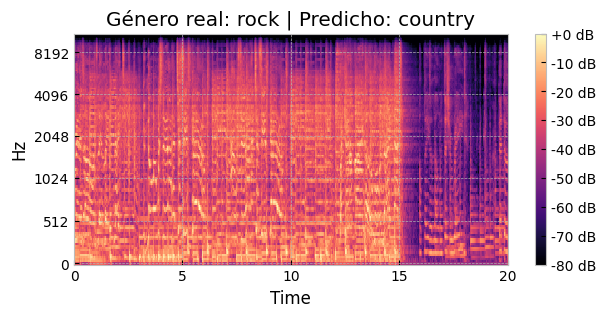

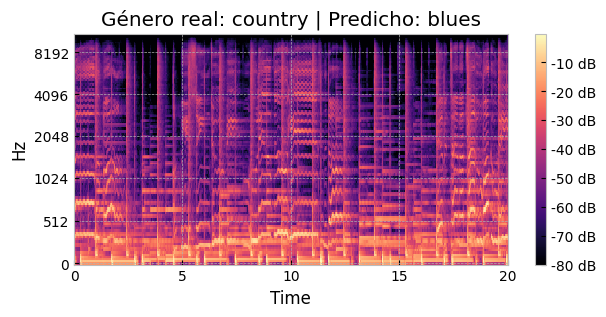

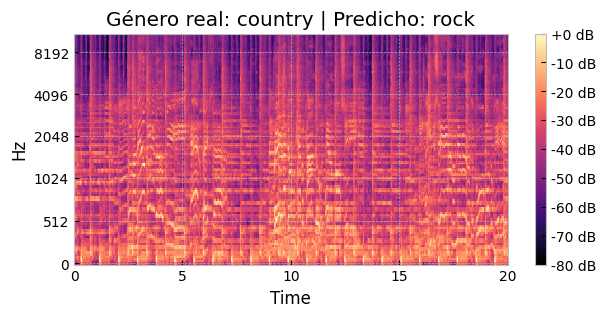

In [15]:
num_examples = 5
indices = np.random.choice(len(test_dataset), num_examples, replace=False)

for idx in indices:
    spec, label_idx = test_dataset[idx]
    spec = spec.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(spec)
        pred_idx = torch.argmax(output, 1).item()
    true_genre = GENRES[label_idx]
    pred_genre = GENRES[pred_idx]
    plt.figure(figsize=(7,3))
    librosa.display.specshow(spec.cpu().squeeze().numpy(), y_axis='mel', x_axis='time')
    plt.title(f"Género real: {true_genre} | Predicho: {pred_genre}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

#### Análisis de resultados

El desempeño observado en la matriz de confusión y los ejemplos muestra la capacidad del modelo para distinguir entre géneros musicales a partir de fragmentos cortos de audio. Sin embargo, ciertos géneros pueden confundirse más fácilmente debido a similitudes rítmicas o instrumentales. La precisión global puede mejorarse ajustando la arquitectura, los hiperparámetros o empleando técnicas adicionales de procesamiento y aumento de datos.

### Ejemplos de uso del modelo entrenado

En esta sección se muestran ejemplos del uso del modelo ya entrenado, realizando predicciones sobre espectrogramas nuevos o seleccionados aleatoriamente del conjunto de prueba. Se visualizan los resultados junto con la comparación entre la etiqueta real y la predicción del modelo.

#### Predicción sobre ejemplos aleatorios del conjunto de prueba

A continuación, se seleccionan al azar algunos ejemplos del conjunto de prueba; para cada uno se muestra el espectrograma, el género real y el género predicho por el modelo.

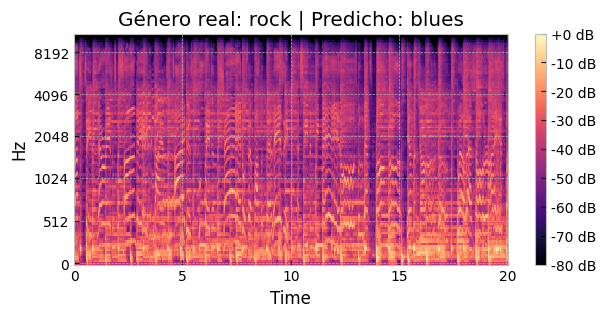

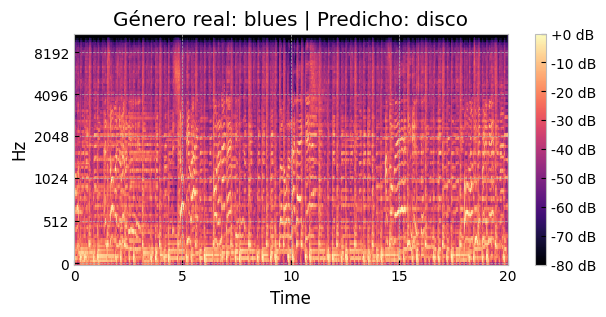

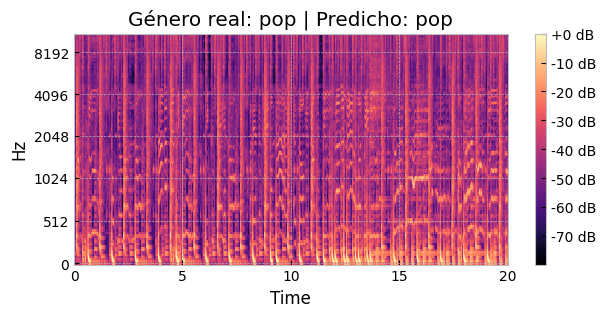

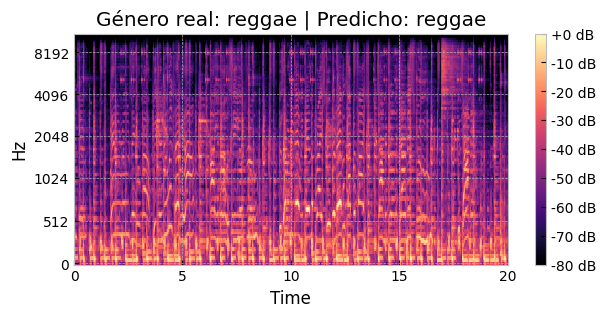

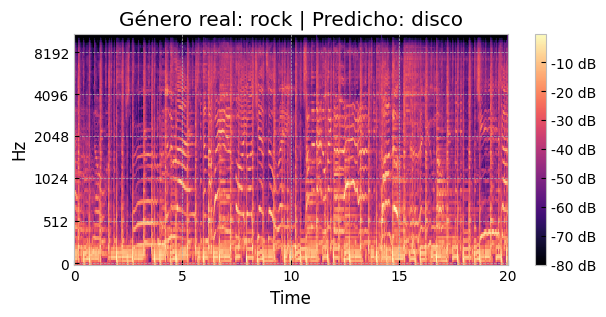

In [16]:
num_ejemplos = 5  # Puedes ajustar el número de ejemplos a mostrar

for _ in range(num_ejemplos):
    idx = np.random.randint(len(test_dataset))
    spec, label_idx = test_dataset[idx]
    spec_tensor = spec.unsqueeze(0).to(device)  # Añadir batch dimension
    model.eval()
    with torch.no_grad():
        output = model(spec_tensor)
        pred_idx = torch.argmax(output, 1).item()
    true_genre = GENRES[label_idx]
    pred_genre = GENRES[pred_idx]
    plt.figure(figsize=(7, 3))
    librosa.display.specshow(spec.cpu().squeeze().numpy(), y_axis='mel', x_axis='time')
    plt.title(f'Género real: {true_genre} | Predicho: {pred_genre}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

#### Observaciones

En los ejemplos anteriores puede observarse cómo el modelo acierta o falla al clasificar los géneros musicales. Esto permite identificar posibles patrones de confusión y reflexionar sobre la robustez del modelo en situaciones reales.

### Conclusiones y observaciones finales

En este apartado se presentan las conclusiones obtenidas tras el desarrollo y experimentación con la red neuronal para clasificación de géneros musicales. También se discuten posibles mejoras y futuras líneas de trabajo para optimizar el desempeño del modelo.

#### Reflexión sobre los resultados

El modelo basado en redes neuronales convolucionales demostró ser capaz de identificar patrones característicos en los espectrogramas de fragmentos cortos de audio, logrando una precisión considerable en la clasificación de géneros musicales. La visualización de la matriz de confusión permitió identificar ciertos géneros que tienden a confundirse, lo cual puede deberse a similitudes en ritmos, instrumentación o patrones armónicos.

Entre los factores que influyen en el desempeño están:
- La cantidad y diversidad de los datos disponibles.
- La duración de los fragmentos analizados.
- La arquitectura y los hiperparámetros del modelo.

#### Posibles mejoras

- Probar arquitecturas más profundas o utilizar modelos preentrenados en tareas similares.
- Aplicar técnicas de aumento de datos (data augmentation) para mejorar la generalización.
- Ajustar hiperparámetros como el learning rate, número de filtros, tamaño de los kernels, etc.
- Experimentar con otras representaciones del audio, como MFCC o chromagrams.
- Implementar regularización adicional o estrategias de early stopping.

En resumen, el proyecto demuestra el potencial de las redes neuronales para el análisis y clasificación automática de audio, abriendo la puerta a aplicaciones más avanzadas en el procesamiento y organización de música.

### Guardado de pesos/modelo

En esta sección se muestra cómo guardar los pesos del modelo entrenado, lo cual permite reutilizar el modelo en el futuro sin necesidad de volver a entrenarlo desde cero.

#### Guardar los pesos del modelo entrenado

Utilizaremos la función `torch.save` para almacenar los parámetros aprendidos por la red neuronal en un archivo. Este archivo puede ser cargado posteriormente para realizar predicciones o continuar el entrenamiento.

In [17]:
# Guardar solo los pesos del modelo
torch.save(model.state_dict(), 'music_genre_cnn_weights.pth')

# Si deseas guardar el modelo completo (estructura + pesos), usa:
# torch.save(model, 'music_genre_cnn_entero.pth')

print("Pesos del modelo guardados exitosamente en 'music_genre_cnn_weights.pth'.")

Pesos del modelo guardados exitosamente en 'music_genre_cnn_weights.pth'.
